# Titration of Rate 16.50 bug analysis

## Object

Analysis of the impact of 16.50 Medium titration bug

## Background

### To reproduce

1. activate configuration : Medium Titration (default is off) set to On. Generates log event 233 with values 'On'/'Off'
2. set authorization level set to **Medium**. Generates log event 58 . Autherization level set with values: 'Technician', 'High', 'Medium', 'Low'.
3. Under Medium authorization New is blocked. Start via repeat last. May be common in epidural mode in UK
4. Change rate
   1. Normal: Under 16.20 Generates log event 376. Rate was changed
   2. Bug: under 16.50 prompts for key and generates log event 387. Authorization fail ['High', 'Medium']

### Summary of required log events for analysis

| Event code | Description | Variable | Details |
|----------|----------|----------|----------|
| 233 | Medium Authorization level titration set to | On,Off | required state to reproduce error|
| 376 | rate was changed | new rate | Expected in 16.20 only         |
| 58 | Authorization level changed | Low,Medium,High,Technician | Medium state required to reproduce error|
| 51 | Delivery mode |Continuous, Intermittent, TPN, PCA, Secondary, Multi-step, Epidural PCA, Epidural Intermittent, Epidural| Required to monitor failure modes |
| 387 | Invalid password attempt | [High, Medium]| Expected log event in failed 16.50 rate change|
| 57 | Power On| | Resets authorization level from Technician to Medium|
| 73 | New infusion started | | Indicates a Technician/High authorization infusion start |
| 222 | New Treatment Wizard Initiated | | Indicates a new infusion treatment|
|202 | Repeat last infusion | | Indicates milestone in Medium authorization infusion start |
|123 | SW version updrade | major version, minor version| Indicates version change|
|130| Infusion ended with info| Info| Indicates end of infusion|

## Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import os
import re

### Importing raw data

Set raw data paths

In [3]:
data_path = os.getenv('SHARED_DATA_PATH')  # env variable for data storage
logevents_path = os.path.join(data_path, r'titration_of_rate\logevents.csv')
logevents_233_path = os.path.join(data_path, r"titration_of_rate\233logevents.csv")
# these files are used to construct the total treatment list
us_excel_data = os.path.join(data_path, r"titration_of_rate\us-treatments.xlsx")
eu_excel_data = os.path.join(data_path, r"titration_of_rate\eu-treatments.xlsx")
# this path points to the total treatments csv
treatments_path = os.path.join(data_path, r"titration_of_rate\treatments.csv")
accountid_map_path = os.path.join(data_path, r"static\account_map.pkl")

Get a list of all pump serials that have listed event 233 (Medium titration) in history. Use this list to narrow down all subsequent data sets

logevents_233 is a table of all code 233 events in the elastic DB (only pumps with connect). This table maps all pumps which have the ```Medium Titration``` option set to **On**

In [4]:
usecols = ['code','dateTime', 'index', 'serialNumber', 'values']  # values - string 'On', 
df_c233 = pd.read_csv(logevents_233_path, usecols=usecols)
df_c233['dateTime'] = pd.to_datetime(df_c233['dateTime'], dayfirst=True)
df_c233['index'] = df_c233['index'].str.replace(',', '').astype(int)  # elastic integer strings may contain commas
df_c233.sort_values(by=['serialNumber', 'dateTime'])
# Not shown: for this set all values are ON -> keep only the first occurrence for each serial
df_c233 = df_c233.sort_values('dateTime').groupby('serialNumber', as_index=False).first()
# get a list of all serials with Medium Titration set to On event in history
serials = list([int(x) for x in df_c233['serialNumber'].unique()])
print(f"A total of {len(serials)} serials have Medium Titration set to 'On'")
print(f"Serial numbers:\n {serials}")

A total of 33 serials have Medium Titration set to 'On'
Serial numbers:
 [300234268, 300235397, 300244687, 300273026, 300273182, 300292679, 300316813, 300316851, 300327020, 300332207, 300339933, 300353356, 300359779, 300386836, 300392585, 300405233, 300405239, 300411832, 300413333, 300413343, 300419458, 300419541, 300426241, 300428195, 300428226, 300433481, 360217960, 370022064, 370022098, 370031546, 380019718, 700035793, 700056618]


**Only 33 serials in total are recorded (on elastic) as being potentially effected by this bug**

#### Import raw treatments

execute next block once to generate the full treatments CSV. Concatenates European and USA data, renames column serialNumber to serial_number and sets the correct data types.
After running once the DataFrame can be loaded from ```treatments_path```.

In [5]:
# Helper function required to deal with negative values for 'duration' (bug in raw data) 
def safe_timedelta(x):
    try:
        return pd.to_timedelta(x)
    except ValueError:
        return pd.NaT

# load excel data and merge
us_treatments = pd.read_excel(us_excel_data)
us_treatments['region'] = 'US'
print(f"Imported {len(us_treatments.index)} treatments from US")
eu_treatments = pd.read_excel(eu_excel_data)
eu_treatments['region'] = 'EU'
print(f"Imported {len(eu_treatments.index)} treatments from EU")
# join European and USA data
treatments = pd.concat([us_treatments, eu_treatments])
# treatments.rename(columns={'serialNumber': 'serial_number'}, inplace=True)
treatments['serialNumber'] = pd.to_numeric(treatments['serialNumber'], errors='coerce').astype('Int64')
treatments['startTime'] = pd.to_datetime(treatments['startTime'], format='mixed')
treatments['endTime'] = pd.to_datetime(treatments['endTime'], format='mixed')
treatments['startTime'] = pd.to_datetime(treatments['startTime'], format='mixed')
treatments['endTime'] = pd.to_datetime(treatments['endTime'], format='mixed')
treatments['softwareUpdateTime'] = pd.to_datetime(treatments['endTime'], format='mixed')
treatments['duration'] = treatments['duration'].apply(safe_timedelta)
# Narrow down treatments to serials with Medium Titration set to On
treatments = treatments[treatments['serialNumber'].isin(serials)]
# Save to local CSV to save processing time in subsequent code execution
treatments.to_csv(treatments_path, index=False)
print(f"Treatments saved to: {treatments_path} as csv")

Imported 254189 treatments from US
Imported 19495 treatments from EU
Treatments saved to: C:\Users\aviad.baram\Data\titration_of_rate\treatments.csv as csv


In [6]:
usecols = ['serialNumber', 'startTime', 'endTime' ,'duration', 'treatmentStatus', 'deliverMode', 'region', 'accountProviderID', 'vi', 'vtbiExpected', 'softwareVersion',
'softwareUpdateTime']
treatments = pd.read_csv(treatments_path, usecols=usecols,  dtype={
    'serialNumber': 'int64',
    'treatmentStatus': 'string',
    'deliverMode': 'string',
    'region': 'string',
    'vi': 'float64',
    'accountProviderID': 'string',
    'vtbiExpected': 'float64'},
    parse_dates=['startTime', 'endTime', 'softwareUpdateTime'])
# Convert column to timedelta after loading
treatments['duration'] = pd.to_timedelta(treatments['duration'])
treatment_serials = treatments['serialNumber'].unique()
print(f"Total treatments: {len(treatments.index)}")
print(f"total available serials in treatments: {len(treatment_serials)}")
print(f"Serials: {treatment_serials}")
print(f"{len(serials) - len(treatment_serials)} serials are not in the treatment data")
m_serials = [sr for sr in serials if sr not in treatment_serials]
print(f"Missing serials:\n{m_serials}")

Total treatments: 1407
total available serials in treatments: 28
Serials: [300419458 300353356 300339933 300359779 370022098 700035793 370031546
 370022064 300413333 300392585 300316851 300235397 300327020 300292679
 300413343 300234268 300419541 300428195 300405233 300405239 360217960
 300433481 300428226 300386836 300273026 380019718 300411832 300426241]
5 serials are not in the treatment data
Missing serials:
[300244687, 300273182, 300316813, 300332207, 700056618]


In [7]:
accounts = treatments.loc[treatments['serialNumber'].isin(treatment_serials), ['serialNumber', 'accountProviderID']]
accounts = accounts.drop_duplicates(subset='serialNumber', keep='first')
accountid_map = pd.read_pickle(accountid_map_path)
accounts = accounts.merge(accountid_map, left_on='accountProviderID', right_on='accountid', how='left')
accounts.drop(columns = ['accountProviderID', 'accountid'], inplace=True)

Five serials that recorded a 233 event (i.e. Medium Titration set to On) are missing from data ⇨ not associated with customer id ⇨ assumed these are demonstration pumps

In [8]:
treatments.head()

,accountProviderID,serialNumber,softwareVersion,softwareUpdateTime,treatmentStatus,startTime,endTime,duration,vi,vtbiExpected,deliverMode,region
0,05e6c4b0-c98b-eec0-26fc-7d1d1b57cea4,300419458,16.50.02,2025-05-13 22:22:12+00:00,Completed,2025-05-13 08:03:57+00:00,2025-05-13 22:22:12+00:00,NaT,128.0,128.0,Continuous,US
1,05e6c4b0-c98b-eec0-26fc-7d1d1b57cea4,300419458,16.50.02,2025-05-16 07:32:31+00:00,Completed,2025-05-13 22:22:28+00:00,2025-05-16 07:32:31+00:00,2 days 09:10:03,128.0,128.0,Continuous,US
2,05e6c4b0-c98b-eec0-26fc-7d1d1b57cea4,300419458,16.50.02,2025-05-18 14:39:38+00:00,Partial,2025-05-16 08:53:00+00:00,2025-05-18 14:39:38+00:00,2 days 05:46:38,88.0,1032.0,Continuous,US
3,05e6c4b0-c98b-eec0-26fc-7d1d1b57cea4,300419458,16.50.02,2025-05-23 16:21:07+00:00,Completed,2025-05-18 14:41:06+00:00,2025-05-23 16:21:07+00:00,5 days 01:40:01,682.0,650.0,Continuous,US
4,05e6c4b0-c98b-eec0-26fc-7d1d1b57cea4,300419458,16.50.02,NaT,Ongoing,2025-05-25 03:34:23+00:00,NaT,NaT,22.0,650.0,Continuous,US


### Import raw events

In [9]:
usecols = ['code', 'dateTime', 'description', 'serialNumber', 'index', 'values']
events = pd.read_csv(logevents_path)
events = pd.read_csv(logevents_path, usecols=usecols)
# for debugging and testing - after : remove next line
# events = pd.read_csv(test_path, usecols=usecols)
events['dateTime'] = pd.to_datetime(events['dateTime'], format='mixed')
events['dateTime'] = events['dateTime'].dt.tz_localize('UTC')
events.sort_values(by=['serialNumber', 'dateTime'])
events = events[events['serialNumber'].isin(serials)]
print(f"Total events: {len(events.index)}")
print(f"total available serials in events: {len(events['serialNumber'].unique())}")
print(f"Serials: {events['serialNumber'].unique()}")

Total events: 334870
total available serials in events: 33
Serials: [300428195 300405239 300413333 300235397 300327020 300392585 300316851
 300413343 370022098 300359779 300332207 360217960 300339933 370031546
 370022064 300316813 300419541 300244687 300405233 300433481 300426241
 300428226 300292679 300273026 380019718 300411832 300386836 300234268
 300273182 300353356 300419458 700056618 700035793]


In [10]:
# set the codes required from the exhaustive list of 
codes = [233, # authorization level set to On
    376, # rate was changed - Normal: expected in 16.20
    387, # Invalid password attempt - Bug expected in 16.50 when attempting Medium Titration
     58, # authorization level changed value: Low, Medium,High,Technician
     51, # delivery mode Continuous,Intermittent,TPN,PCA,Secondary,Multi-step,Epidural PCA,Epidural Intermittent,Epidural. sanity check against treatments
     57, # power on. Resets Technician modes to Medium
     73, # new infusion started
     222, # new treatment wizard initiated - indication of started
     74, # pump started
     202,  # repeat last infusion
     123, # SW version stored in value
     130  # infusion ended with info
    ]
events = events[events['code'].isin(codes)]
print("After selecting codes:")
print(f"Total events: {len(events.index)}")

After selecting codes:
Total events: 62444


This function is required to strip array values of the literal array characters. In elastice the arrays ['16', 'Technician'] is stored as the string "'['16', 'Tecnician']'"

In [11]:
def clean_auth_value(val):
    # Extracts the word inside the brackets and quotes, e.g., "['High']" -> 'High'
    match = re.match(r"\['(.+)'\]", str(val))
    if match:
        return match.group(1)
    return val

This function iterates over the events in their chrnological order. It maintains an updated state of the pump and assigns each event a series of attributes representing: state of ```Medium Titration``` setting,  Authorization level, selected infusion mode, software version and a state change flag. The state change flag indicates that the state of the pump changed following this event. 

In [12]:
def set_event_status(events_df):
    """
    Iterates over all serials in events_df. For each event in a serial set:
    Sets a status flag 'med_tit'. The flag starts at 'Off', is set to 'On' if code 233 with value 'On' is encountered, and set back to 'Off' if code 233 with value 'Off' is encountered.
    Sets a value flag for 'level'. The level flag changes on event code 58 and persists from then on excluding Technician level which also resets on pump start
    Sets a value for 'mode'. The mode flag 
    
    """
    events_df = events_df.copy()
    for serial in events_df['serialNumber'].unique():
        serial_mask = events_df['serialNumber'] == serial
        serial_events = events_df[serial_mask].sort_values('dateTime')
        med_tit = []
        levels = []
        modes = []
        version = []
        status_change_flag = []
        current_value = {'med_tit': False, 'mode':'', 'level':'Medium', 'version':''}  # med_titration is Off by default
        for idx, row in serial_events.iterrows():
            status_change_f = False
            if row['code'] == 233:  # Medium Titration setting change event. Values are 'On' and 'Off'
                if clean_auth_value(row['values']).lower() == 'on':
                    med_t = True
                else:
                    med_t = False
                if med_t != current_value['med_tit']:
                    current_value['med_tit'] = med_t
                    status_change_f = True
            if row['code'] == 58:  # Authorization level change event. 
                lvl = clean_auth_value(row['values'])
                if lvl != current_value['level']:
                    current_value['level'] = lvl
                    status_change_f = True
            if row['code'] == 57:  # system start event. Resets level Technician to Medium
                if current_value['level'] == 'Technician':
                    current_value['level'] = 'Medium'
                    status_change_f = True
            if row['code'] == 51:  # Infusion mode set event
                md = clean_auth_value(row['values'])
                if md != current_value['mode']:
                    current_value['mode'] = md
                    status_change_f = True
            if row['code'] == 123:  # version update event
                try:
                    vr = eval(row['values'])
                except:
                    vr = row['values'].split(',')
                    vr = [x.strip() for x in vr]
                vr = vr[0] + '.' + vr[1]
                if vr != current_value['version']:
                    current_value['version'] = vr
                    status_change_f = True
            levels.append(current_value['level'])
            med_tit.append(current_value['med_tit'])
            modes.append(current_value['mode'])
            version.append(current_value['version'])
            status_change_flag.append(status_change_f)
            # Assign lists to the DataFrame for this serial
        events_df.loc[serial_events.index, 'med_tit'] = med_tit
        events_df.loc[serial_events.index, 'level'] = levels
        events_df.loc[serial_events.index, 'mode'] = modes
        events_df.loc[serial_events.index, 'version'] = version
        events_df.loc[serial_events.index, 'status_change_flag'] = status_change_flag
    return events_df

# mark med titration state and level
events = set_event_status(events)


C:\Users\aviad.baram\AppData\Local\Temp\ipykernel_14956\2813576691.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,

### Join events with treatments

assign event to treatment

In [13]:
# count the total number of Medium level 376 type events
def assign_treatment_label(row, treatments_df, available_serials):
    serial = row['serialNumber']
    if serial not in available_serials:
        return 'serial_missing'
    matches = treatments_df[
        (treatments_df['serialNumber'] == serial) &
        (treatments_df['startTime'] <= row['dateTime']) &
        (treatments_df['endTime'] >= row['dateTime'])
    ]
    if not matches.empty:
        return matches.index[0]  # return the treatments id
    else:
        return 'out_of_treatment'  # event occurred outside the context of treatment events

# Precompute available serials for efficiency
available_serials = set(treatments['serialNumber'].unique())

# Assign treatment label to each event
events['treatment_assignment'] = events.apply(
    lambda row: assign_treatment_label(row, treatments, available_serials), axis=1
)

Assign SW version to each event based on treatment assignment

In [14]:
version_info = treatments.loc[treatments['serialNumber'].isin(available_serials)]
# a total of 341 treatments are identified
def assign_version_flag(row):
    # If not associated with a treatment, assign 'NA'
    if row['treatment_assignment'] in ('serial_missing', 'out_of_treatment')  or pd.isna(row['treatment_assignment']):
        return 'NA'
    # If last_software_update is after the event, assign 'ambiguous'
    version = treatments.loc[row['treatment_assignment'],'softwareVersion']
    update_time = treatments.loc[row['treatment_assignment'], 'softwareUpdateTime']
    if update_time > row['dateTime']:  # update occurred after event time stamp
        return 'ambiguous'
    # Otherwise, assign the current_software_version
    return version

events['version_flag'] = events.apply(assign_version_flag, axis=1)

### calculate significance of differences

calculate probabilities for a prompt for password in an infusion treatment with Medium authorization and Medium Titration set to **On**

In [15]:
versions = list(events['version'].unique())
versions.remove('')
print(f"Available versions: {versions}")

Available versions: ['11.50', '16.20', '15.10', '16.0', '13.1', '15.0', '13.23', '13.11', '11.53', '13.12', '16.10', '16.50', '13.22', '16.21']


In [16]:
infusions = []
rate_changes = []
pw_fails_indices = []
pw_fail_counts = []
pw_fail_probs = []
pw_fails_modes = []
for ver in versions:
    infusion = events.loc[(events['version'] == ver)  &
                                      (events['code'].isin([202, 73])) &
                                      (events['level'] == 'Medium') &
                                      (events['med_tit'])].shape[0]
    infusions.append(infusion)
    rate_change = events.loc[(events['version'] == ver)  &
                                      (events['code'] == 376) &
                                      (events['level'] == 'Medium') &
                                      (events['med_tit'])].shape[0]
    rate_changes.append(rate_change)
    pw_fail_idx = events.loc[(events['version'] == ver)  &
                                      (events['code'] == 387) &
                                      (events['level'] == 'Medium') &
                                      (events['med_tit'])].index
    pw_fails_indices.append(pw_fail_idx)
    modes = events.loc[pw_fail_idx, 'mode'].value_counts()
    modes = modes/modes.sum()
    pw_fails_modes.append(modes)
    pw_fail_count = len(events.loc[pw_fail_idx].groupby('treatment_assignment'))
    pw_fail_counts.append(pw_fail_count)
    if infusion != 0:
        pw_fail_prob = 100 * pw_fail_count/infusion
    else:
        pw_fail_prob = np.nan
    pw_fail_probs.append(pw_fail_prob)

# Create a summary DataFrame for the calculated statistics
summary_df = pd.DataFrame({
    'infusions': infusions,
    'rate_changes': rate_changes,
    'pw_fail_counts': pw_fail_counts,
    'pw_fail_probs': pw_fail_probs
}, index=versions)
# Set index name
summary_df.index.name = 'version'
display(summary_df)

,infusions,rate_changes,pw_fail_counts,pw_fail_probs
version,,,,
11.50,0,0,0,NaN
16.20,198,2,6,3.030303
15.10,40,3,1,2.500000
16.0,7,0,1,14.285714
13.1,0,0,0,NaN
15.0,14,0,1,7.142857
13.23,0,0,0,NaN
13.11,0,0,0,NaN
11.53,0,0,0,NaN


In [17]:
modes_df = pd.DataFrame(pw_fails_modes, index=versions)
modes_df = modes_df.dropna(how='all')
display(modes_df)

mode,Continuous,PCA,Multi-step,Intermittent,Epidural PCA,TPN,Epidural Intermittent
16.20,0.619048,0.360544,0.013605,0.006803,NaN,NaN,NaN
15.10,0.266667,0.066667,NaN,NaN,0.555556,0.066667,0.044444
16.0,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
15.0,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
16.10,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
16.50,0.228571,0.171429,0.285714,NaN,0.228571,NaN,0.085714


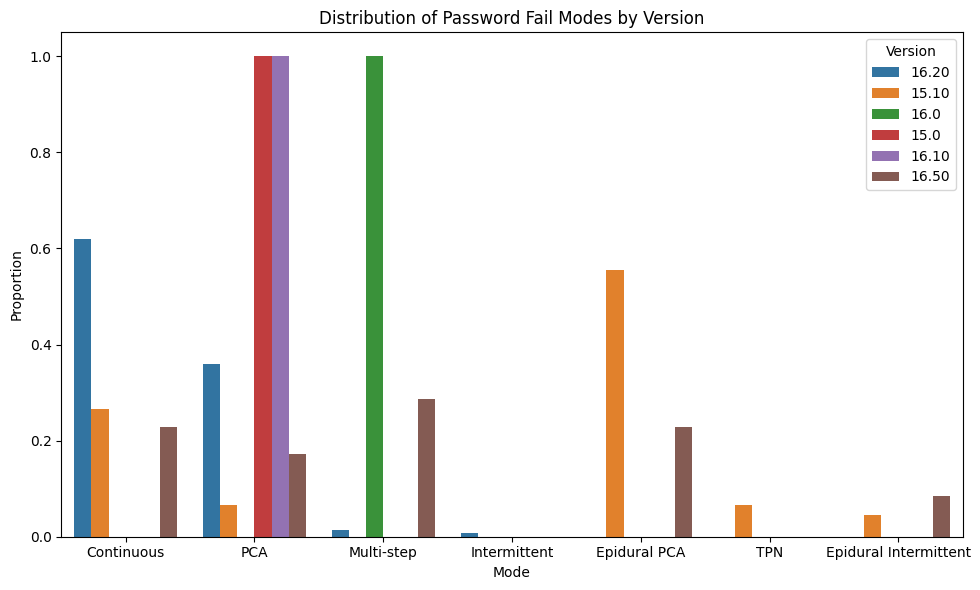

In [18]:
modes_df_filled = modes_df.fillna(0)
modes_long = modes_df_filled.reset_index().melt(id_vars='index', var_name='mode', value_name='proportion')
modes_long = modes_long.rename(columns={'index': 'version'})
plt.figure(figsize=(10, 6))
sns.barplot(data=modes_long, x='mode', y='proportion', hue='version')
plt.title('Distribution of Password Fail Modes by Version')
plt.ylabel('Proportion')
plt.xlabel('Mode')
plt.legend(title='Version')
plt.tight_layout()
plt.show()

In [35]:
events.head()

,code,dateTime,description,serialNumber,index,values,med_tit,level,mode,version,status_change_flag,treatment_assignment,version_flag
15,57,2022-05-09 18:11:36+00:00,Power on,300316813,1,[],False,Medium,,,False,serial_missing,NA
135,123,2000-01-01 01:02:16+00:00,Software uploaded 11.50.0 6028,300428195,6,"['11', '50', '0', '', '6028']",False,Technician,,11.50,True,out_of_treatment,NA
137,123,2000-01-01 01:03:33+00:00,Software uploaded 11.50.0 60496,300413333,6,"['11', '50', '0', '', '60496']",False,Technician,,11.50,True,out_of_treatment,NA
151,123,2000-01-01 00:57:06+00:00,Software uploaded 11.50.0 60496,300419541,6,"['11', '50', '0', '', '60496']",False,Technician,,11.50,True,out_of_treatment,NA
154,123,2000-01-01 01:07:23+00:00,Software uploaded 11.50.0 6028,300433481,6,"['11', '50', '0', '', '6028']",False,Technician,,11.50,True,out_of_treatment,NA


In [34]:
fail_long = []
for indices, ver in zip(pw_fails_indices, versions):
    if len(indices) == 0:
        continue
    instance_fails = events.loc[indices, 'serialNumber'].value_counts(normalize=True).to_frame('proportion').reset_index()
    instance_fails = instance_fails.merge(accounts, left_on='serialNumber', right_on='serialNumber', how='left')
    instance_fails.drop(columns=['serialNumber'], inplace=True)
    instance_fails = instance_fails.assign(Version=ver)
    fail_long.append(instance_fails)
fail_long = pd.concat(fail_long, ignore_index=True)[['account', 'proportion', 'Version']]

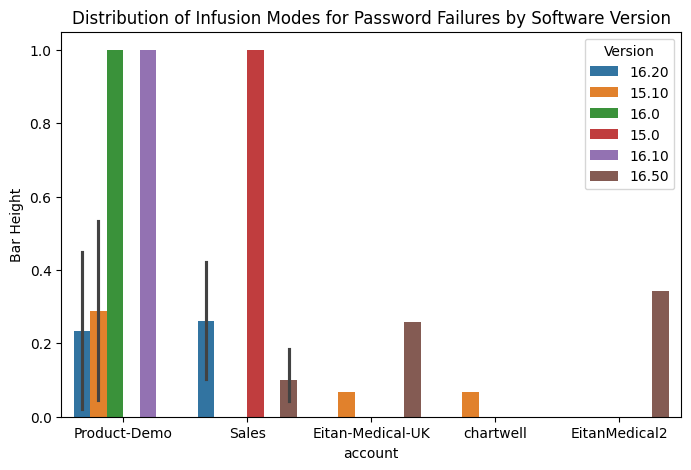

In [37]:
# Make grouped bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=fail_long, x='account', y='proportion', hue='Version')
plt.title("Distribution of Infusion Modes for Password Failures by Software Version")
plt.ylabel("Bar Height")
plt.show()

perform Z-test to verify the two proportions come from different population

**z-statistic** measures how many standard errors the observed difference in sample proportions is away

**p-value** measures the probability of observing a difference as extreme or more extreme than the one observed, assuming the null hypothesis is true

In [41]:

count = [summary_df.loc['16.20', 'pw_fail_counts'], summary_df.loc['16.50', 'pw_fail_counts']]  # number of successes in each sample
nobs =  [summary_df.loc['16.20', 'infusions'], summary_df.loc['16.50', 'infusions']]  # number of trials in each sample

stat, pval = proportions_ztest(count, nobs)
print(f"Z-statistic 16.50 vs 16.20: {stat:.4f}, p-value: {pval:.4f}")

count = [summary_df.loc['16.20', 'pw_fail_counts'], summary_df.loc['15.0', 'pw_fail_counts']]  # number of successes in each sample
nobs =  [summary_df.loc['16.20', 'infusions'], summary_df.loc['15.0', 'infusions']]  # number of trials in each sample

stat, pval = proportions_ztest(count, nobs)
print(f"Z-statistic 16.20 vs 15.0: {stat:.4f}, p-value: {pval:.4f}")

Z-statistic 16.50 vs 16.20: -10.7263, p-value: 0.0000
Z-statistic 16.20 vs 15.0: -0.8322, p-value: 0.4053


Absolute value of Z-statistic for 16.20 vs. 16.50 is **very** high almost certainly not due to chance. The p-value is very small ⇨ this difference is likely significant.

As a reference, the Z-statistic for 16.20 vs 15.0 is interpreted as these two ratios being drawn from the same population.

### Conclusions

1. The number of occurrences is very small.
2. Number of affected pumps (worldwide) estimated ~ 1100.
3. Affected pumps are associated with Eitan Medical accounts.
4. Extremely significant difference; almost zero chance this difference is random.